<a href="https://colab.research.google.com/github/lpy0927/Edge-computing-data-transmission-for-virtual-reality/blob/main/3Dpredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
import plotly.graph_objs as go
from matplotlib.pyplot import cm
from keras.models import Model
import numpy as np
import keras
import h5py
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
init_notebook_mode(connected=True)
%matplotlib inline


In [ ]:
#read the dataset from the 3DMINIST
with h5py.File('full_dataset_vectors.h5', 'r') as dataset:
    x_train = dataset["X_train"][:]
    x_test = dataset["X_test"][:]
    y_train = dataset["y_train"][:]
    y_test = dataset["y_test"][:]

In [ ]:
#print the data shape
print ("x_train shape: ", x_train.shape)
print ("y_train shape: ", y_train.shape)
print ("x_test shape:  ", x_test.shape)
print ("y_test shape:  ", y_test.shape)

x_train shape:  (10000, 4096)
y_train shape:  (10000,)
x_test shape:   (2000, 4096)
y_test shape:   (2000,)


In [ ]:
## Introduce the channel dimention in the input dataset
xtrain = np.ndarray((x_train.shape[0], 4096, 3))
xtest = np.ndarray((x_test.shape[0], 4096, 3))

## iterate in train and test, add the rgb dimention
def add_rgb_dimention(array):
    scaler_map = cm.ScalarMappable(cmap="Oranges")
    array = scaler_map.to_rgba(array)[:, : -1]
    return array
for i in range(x_train.shape[0]):
    xtrain[i] = add_rgb_dimention(x_train[i])
for i in range(x_test.shape[0]):
    xtest[i] = add_rgb_dimention(x_test[i])

## convert to 1 + 4D space (1st argument represents number of rows in the dataset)
xtrain = xtrain.reshape(x_train.shape[0], 16, 16, 16, 3)
xtest = xtest.reshape(x_test.shape[0], 16, 16, 16, 3)

## convert target variable into one-hot
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [ ]:
# use logistic regression model to predict the data and get the accuracy result
model_logisticRegression = LogisticRegression()
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test,axis=1)
model_logisticRegression.fit(xtrain.reshape(xtrain.shape[0],-1),y_train_labels)
y_pred = model_logisticRegression.predict(xtest.reshape(xtest.shape[0],-1))
accuracy = accuracy_score(y_test_labels,y_pred)
print('accuracy:', accuracy)

accuracy: 0.6135


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [ ]:
# use the random forest classifier to predict the data and get the accuracy result
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(x_train,y_train)
y_pred = rf_classifier.predict(x_test)
accuracy = accuracy_score(y_test,y_pred)
print('accuracy: ',accuracy)

accuracy:  0.3805


In [ ]:
# use the CNN model to predict the data and get the accuracy result
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.datasets import mnist
# Define CNN model
model = models.Sequential()
model.add(layers.Conv3D(32, (3, 3, 3), activation='relu', input_shape=(16,16,16,3)))
model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(layers.Conv3D(64, (3, 3, 3), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(layers.Conv3D(64, (2,2,2), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(xtrain, y_train, epochs=20, batch_size=64, validation_data=(xtest, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(xtest, y_test)
print('Test accuracy:', test_acc)

Epoch 1/20
157/157 [==============================] - 117s 738ms/step - loss: 2.2146 - accuracy: 0.1744 - val_loss: 1.8913 - val_accuracy: 0.3250
Epoch 2/20
157/157 [==============================] - 111s 705ms/step - loss: 1.8008 - accuracy: 0.3743 - val_loss: 1.6701 - val_accuracy: 0.4125
Epoch 3/20
157/157 [==============================] - 114s 729ms/step - loss: 1.5661 - accuracy: 0.4665 - val_loss: 1.4132 - val_accuracy: 0.4970
Epoch 4/20
157/157 [==============================] - 111s 709ms/step - loss: 1.4051 - accuracy: 0.5148 - val_loss: 1.3093 - val_accuracy: 0.5210
Epoch 5/20
157/157 [==============================] - 115s 732ms/step - loss: 1.3110 - accuracy: 0.5389 - val_loss: 1.2886 - val_accuracy: 0.5520
Epoch 6/20
157/157 [==============================] - 111s 705ms/step - loss: 1.2589 - accuracy: 0.5575 - val_loss: 1.2009 - val_accuracy: 0.5615
Epoch 7/20
157/157 [==============================] - 113s 721ms/step - loss: 1.2000 - accuracy: 0.5839 - val_loss: 1.1959 -

In [ ]:
# add the noise to the data
def laplace_mechanism(original_data, sensitivity, epsilon):
    noise_shape = original_data.shape  # Get the shape of the original data
    scale = sensitivity / epsilon
    noise = np.random.laplace(scale=scale, size=noise_shape)
    private_data = original_data + noise
    return private_data

def compressed_LDP_mechanism(original_data, sensitivity,epsilon):
    noisy_data = laplace_mechanism(original_data,sensitivity,epsilon)

    serialized_data = pickle.dumps(noisy_data)
    compressed_data = gzip.compress(serialized_data)

    return compressed_data

def Gaussian_mechanism(original_data, sensitivity,epsilon):
    scale = sensitivity/epsilon
    noisy_data = np.random.normal(scale=scale,size=original_data.shape)
    return noisy_data



In [ ]:
# get the different epsilon accuracy results
RandomForest = RandomForestClassifier()
epsilons = [0.1,0.2,0.5,1,1.2,1.5,2,2.2,2.5,3]
results = []
for epsilon in epsilons:
  sensitivity = 1
  xtrain = xtrain.reshape(xtrain.shape[0],-1)
  xtest = xtest.reshape(xtest.shape[0],-1)
  y_train_labels = np.argmax(y_train, axis=1)
  y_test_labels = np.argmax(y_test, axis=1)
  x_train_noise = laplace_mechanism(xtrain,sensitivity,epsilon)
  model_logisticRegression.fit(x_train_noise, y_train_labels)
  result = model_logisticRegression.predict(xtest)
  accuracy = accuracy_score(y_test_labels, result)
  print(accuracy)
  results.append(accuracy)

0.2345


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.3215


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.444


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.5155


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.5425


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.5595


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.573


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.587


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.5885
0.611


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [ ]:
import matplotlib.pyplot as plt

In [ ]:
print(results)

[0.2345, 0.3215, 0.444, 0.5155, 0.5425, 0.5595, 0.573, 0.587, 0.5885, 0.611]


In [ ]:
def plot_results(epsilons, test_acc):
  plt.plot(epsilons,test_acc,color='black')
  plt.xlabel('Different privacy parameters')
  plt.ylabel('Accuracy (%)')
  plt.legend()
  plt.show()

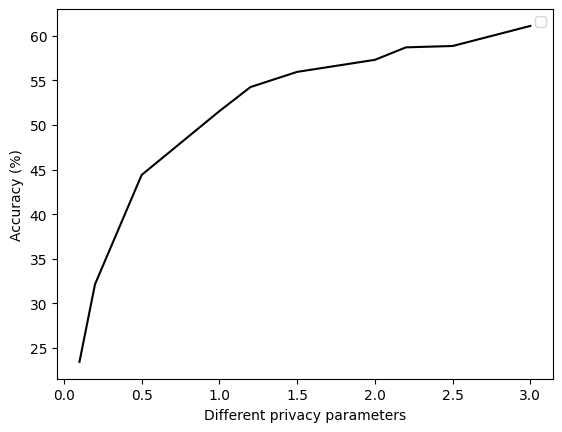

In [ ]:
result_data=[]
for result in results:
  result_data.append(result*100)
plot_results(epsilons,result_data)

In [ ]:

# get the membership inference attack resutls under different epsilons
epsilons = [0.1,0.2,0.5,1.0,2.0,3.0]
attack_results=[]
sensitivity = 1.0
def add_laplace_noise(data, epsilon):
  noisy_data = data + np.random.laplace(scale=sensitivity/epsilon, size=data.shape)
  return noisy_data
def membership_inference_attack(epsilon,xtrain,y_train,xtest,y_test):
  x_train_noise = add_laplace_noise(xtrain,epsilon)
  clf = LogisticRegression()
  clf.fit(x_train_noise,y_train)
  ypred= clf.predict(xtest)
  accuracy = accuracy_score(y_test, ypred)
  return accuracy




In [ ]:
# get the attack results
for epsilon in epsilons:
  xtrain = xtrain.reshape(xtrain.shape[0],-1)
  xtest = xtest.reshape(xtest.shape[0],-1)
  y_train_labels = np.argmax(y_train, axis=1)
  y_test_labels = np.argmax(y_test, axis=1)
  accuracy=membership_inference_attack(epsilon,xtrain,y_train_labels,xtest,y_test_labels)
  print(accuracy)
  attack_results.append(accuracy)

In [ ]:
# plot the data
def plot_membership_inference_results(epsilons, attack_results):
  privacys = []
  for i in attack_results:
    privacy = (1-i)*100
    privacys.append(privacy)
  plt.plot(epsilons,privacys)
  plt.xlabel('Different privacy parameters')
  plt.ylabel('Privacy results (%)')
  plt.legend()
  plt.show()

In [ ]:
print(attack_results)
plot_membership_inference_results(epsilons,attack_results)

In [ ]:
# use the different privacy methods to evaluate the data
def run_experiments(xtrain,y_train,xtest,y_test):
  privacy_methods = ['CDP','LDP','Gaussian','SMPC','LDPET']
  sensitivity = 1
  epsilons = [0.1,0.2,0.5,1.0,1.5,2.0,2.5,3.0]
  results = np.zeros((len(privacy_methods),len(epsilons)))
  xtrain = xtrain.reshape(xtrain.shape[0],-1)
  xtest = xtest.reshape(xtest.shape[0],-1)
  y_train_labels = np.argmax(y_train, axis=1)
  y_test_labels = np.argmax(y_test, axis=1)
  for method in privacy_methods:
    for epsilon in epsilons:
      if method == 'CDP':
        print('CDP:',epsilon)
        X_train_noise = Gaussian_mechanism(xtrain,sensitivity,epsilon)
      if method == 'LDP':
        print('LDP:',epsilon)
        X_train_noise = laplace_mechanism(xtrain,sensitivity,epsilon)
      if method == 'Gaussian':
        print('Gaussian:',epsilon)
        X_train_noise = Gaussian_mechanism(xtrain,sensitivity,epsilon)
      if method == 'SMPC':
        print('SMPC:')
        X_train_noise = xtrain + 1
      if method == 'LDPET':
        print('LDPET:',epsilon)
        X_privacy_compressed = compressed_LDP_mechanism(xtrain, sensitivity,epsilon)
        serialized_data = gzip.decompress(X_privacy_compressed)
        X_privacy_preserved = pickle.loads(serialized_data)
        X_train_noise = X_privacy_preserved + 0.1
      model_logisticRegression.fit(X_train_noise, y_train_labels)
      result = model_logisticRegression.predict(xtest)
      accuracy = accuracy_score(y_test_labels,result)
      print(accuracy)
      results[privacy_methods.index(method)][epsilons.index(epsilon)] = accuracy
  return privacy_methods, results

In [ ]:
# plot the results
def plot_methods_results(privacy_methods, results):
  colors=['blue','green','red','purple','black']
  for i, method in enumerate(privacy_methods):
    for j,epsilon in enumerate(epsilons):
      plt.plot(epsilons[j],results[j][i]*100,width=0.1,color=colors[i],label=privacy_methods[i])
  plt.xlabel('Different Epsilons')
  plt.ylabel('Accuracy (%)')
  plt.legend()
  plt.show()

In [ ]:
import pickle
import gzip

In [ ]:
privacy_methods,results = run_experiments(xtrain,y_train,xtest,y_test)

CDP: 0.1
0.126
CDP: 0.2
0.0855
CDP: 0.5
0.094
CDP: 1.0
0.1155
CDP: 1.5
0.105
CDP: 2.0
0.083
CDP: 2.5
0.0935
CDP: 3.0
0.087
LDP: 0.1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.196
LDP: 0.2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.292
LDP: 0.5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.443
LDP: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.5255
LDP: 1.5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.5585
LDP: 2.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.5655
LDP: 2.5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.588
LDP: 3.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.601
Gaussian: 0.1
0.126
Gaussian: 0.2
0.085
Gaussian: 0.5
0.092
Gaussian: 1.0
0.087
Gaussian: 1.5
0.126
Gaussian: 2.0
0.087
Gaussian: 2.5
0.107
Gaussian: 3.0
0.089
SMPC:


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.3845
SMPC:


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.3845
SMPC:


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.3845
SMPC:


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.3845
SMPC:


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.3845
SMPC:


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.3845
SMPC:


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.3845
SMPC:


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.3845
LDPET: 0.1
0.227
LDPET: 0.2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.32
LDPET: 0.5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.471
LDPET: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.528
LDPET: 1.5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.546
LDPET: 2.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.5615
LDPET: 2.5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.5675
LDPET: 3.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.578


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# get the results and plot it
result_cdp = [12.6,8.55,9.4,11.55,10.5,8.3,9.35,8.7]
result_ldp = [19.6,29.2,44.3,52.55,55.85,56.55,58.5,60.1]
result_gaussian = [12.6,8.5,9.2,8.7,12.6,8.7,10.7,8.9]
result_smpc = [38.45,38.45,38.45,38.45,38.45,38.45,38.45,38.45]
result_ldpet = [22.7,32.0,47.1,52.8,54.6,56.15,56.75,57.8]
def plot_results_different_methods(epsilon):
  plt.plot(epsilon,result_cdp,label='CDP')
  plt.plot(epsilon,result_ldp,label='LDP')
  plt.plot(epsilon,result_gaussian,label='Gaussian')
  plt.plot(epsilon,result_smpc,label='SMPC')
  plt.plot(epsilon,result_ldpet,label='LDPET')
  plt.xlabel('Different Epsilons')
  plt.ylabel('Accuracy (%)')
  plt.legend()
  plt.show()

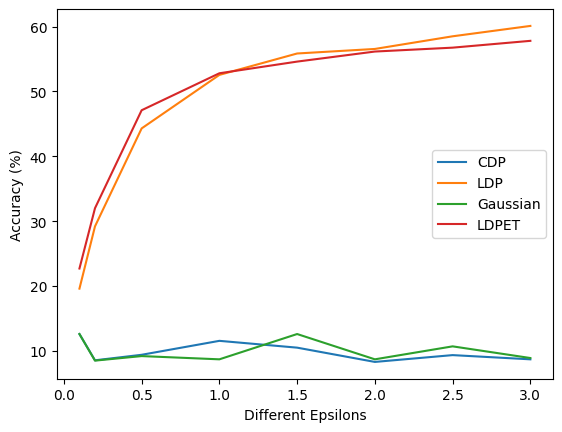

In [ ]:
epsilons = [0.1,0.2,0.5,1.0,1.5,2.0,2.5,3.0]
plot_results_different_methods(epsilons)

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBClassifier

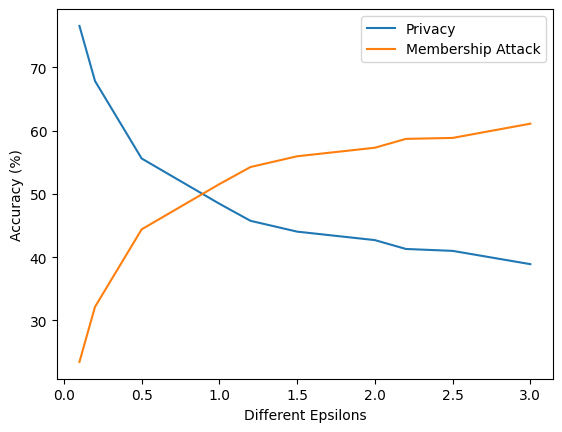

In [ ]:
# according to all the results and plot the
import matplotlib.pyplot as plt
membership_attack_results = [23.45, 32.15, 44.4, 51.55, 54.25, 55.95, 57.3, 58.7, 58.85, 61.1]
privacy_results = [76.55,67.85,55.6,48.45,45.75,44.04,42.7,41.3,41,38.9]
epsilons = [0.1,0.2,0.5,1.0,1.2,1.5,2.0,2.2,2.5,3.0]
plt.plot(epsilons,privacy_results,label='Privacy')
plt.plot(epsilons,membership_attack_results,label='Membership Attack')
plt.xlabel('Different Epsilons')
plt.ylabel('Accuracy (%)')
plt.legend()